# Forecasting power consumption in Tetouan city using Deep Learning Time Series techniques

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4) 
* [One-step univariate forecasting](#5) 
    * [Timeseries Data Preparation](#6)    
        * [Train - Test split of timeseries dataset](#7)       
    * [Timeseries Model Building](#8)
        * [Data Preprocessing](#9)  
        * [Model Initialization ](#10)
        * [Learning Rate Search ](#11)
    * [Model Training ](#12) 
    * [Power Consumption Forecast & Validation](#13)   
        * [Forecasting Using the trained Timeseries Model](#14)
        * [Estimate model metrics for validation](#15)
    * [Result Visualization](#16)
* [Multi-Step Multivariate Forecasting](#17) 
    * [Timeseries Data Preparation](#18)    
        * [Train - Test split of timeseries dataset](#19)       
    * [Timeseries Model Building](#20)
        * [Data Preprocessing](#21)  
        * [Model Initialization ](#22)
        * [Learning Rate Search ](#23)
    * [Model Training ](#24) 
    * [Power Consumption Forecast & Validation](#25)   
        * [Forecasting Using the trained Timeseries Model](#26)
        * [Estimate model metrics for validation](#27)
    * [Result Visualization](#28)
* [One-Step multivariate forecasting](#29) 
    * [Timeseries Data Preparation](#30)  
        * [Formatting the input dataframe ](#31)
        * [Train - Test split of timeseries dataset](#32)       
    * [Timeseries Model Building](#33)
        * [Data Preprocessing](#34)  
        * [Model Initialization ](#35)
        * [Learning Rate Search ](#36)
    * [Model Training ](#37) 
    * [Power Consumption Forecast & Validation](#38)   
        * [Forecasting Using the trained Timeseries Model](#39)
        * [Estimate model metrics for validation](#40)
    * [Result Visualization](#41)
* [Conclusion](#42)
* [Data resources](#43)

## Introduction <a class="anchor" id="1"></a>

In this notebook, we will forecast the power consumption of Tetouan city for one day in 10 minute increments using Deep Learning Series techniques. This short term time series forecasting can be crucial in optimizing grid operations, enhancing reliability, reducing costs, and facilitating the integration of renewable energy sources, and it can serve as a vital tool that will allow utilities to adapt to changing demand patterns and move towards a more sustainable future.


This process involves the use of advanced deep learning models to predict future electricity usage based on historical data. We'll explore three different methods of forecasting, each utilizing the following specialized timeseries backbones:

 - One-Step Univariate Forecasting with Bidirectional LSTM
 - Multi-Step Multivariate Forecasting with InceptionTime
 - One-Step Multivariate Forecasting with Time Series Transformer

## Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from datetime import datetime as dt
from IPython.display import Image, HTML
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot

from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS("home")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a> 

The dataset employed in this illustrative study consists of a multivariate time series comprising power consumption data recorded every 10 minutes in  [Tetouan city.](#43) The data spans from January 2017 to December 2017, encompassing each day within that timeframe. The multivariate time series consists of historical power consumption, temperature, humidity, wind speed, and other relevant variables. The following cell downloads the data:

<Item title:"Tetouan_city_power_consumption1" type:CSV owner:api_data_owner>
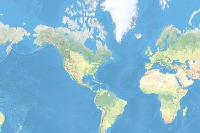

In [3]:
data_table = gis.content.get("c16e532a57bf4900a201dfa5c6e6d1ab")
data_table

In [4]:
# Download the csv and saving it in local folder
data_path = data_table.get_data()

In [5]:
# # Read the csv file
city_power_consumption_df = pd.read_csv(data_path).drop(["Unnamed: 0"], axis=1)
city_power_consumption_df['DateTime'] = pd.to_datetime(city_power_consumption_df['DateTime'])
city_power_consumption_df.head(5)

DateTime  Temperature  Humidity  Wind Speed  \
0 2017-01-01 00:00:00        6.559      73.8       0.083   
1 2017-01-01 00:10:00        6.414      74.5       0.083   
2 2017-01-01 00:20:00        6.313      74.5       0.080   
3 2017-01-01 00:30:00        6.121      75.0       0.083   
4 2017-01-01 00:40:00        5.921      75.7       0.081   

   general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                  0.051          0.119               34055.69620   
1                  0.070          0.085               29814.68354   
2                  0.062          0.100               29128.10127   
3                  0.091          0.096               28228.86076   
4                  0.048          0.085               27335.69620   

   Zone 2  Power Consumption  Zone 3  Power Consumption  \
0                16128.87538                20240.96386   
1                19375.07599                20131.08434   
2                19006.68693                19668.43373   
3                18361.09422                18899.27711   
4                17872.34043                18442.40964   

   Total Power Consumption    Month weekday  hour  
0              70425.53544  January  Sunday   0.0  
1              69320.84387  January  Sunday   0.0  
2              67803.22193  January  Sunday   0.0  
3              65489.23209  January  Sunday   0.0  
4              63650.44627  January  Sunday   0.0

In [6]:
city_power_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   52416 non-null  datetime64[ns]
 1   Temperature                52416 non-null  float64       
 2   Humidity                   52416 non-null  float64       
 3   Wind Speed                 52416 non-null  float64       
 4   general diffuse flows      52416 non-null  float64       
 5   diffuse flows              52416 non-null  float64       
 6   Zone 1 Power Consumption   52416 non-null  float64       
 7   Zone 2  Power Consumption  52416 non-null  float64       
 8   Zone 3  Power Consumption  52416 non-null  float64       
 9   Total Power Consumption    52416 non-null  float64       
 10  Month                      52416 non-null  object        
 11  weekday                    52416 non-null  object        
 12  hour

## One-step univariate forecasting <a class="anchor" id="5"></a> 

Once the data has been downloaded, we will first use one-step univariate forecasting. which we will use as a baseline for more complex forecasting models. In this approach, the model predicts one step ahead at a time. For this study of power consumption, this will mean predicting the usage for the next 10 minutes based solely on the historical values of that specific variable up to the current timestep. Thus, using past observations of the single variable Total Power Consumption, we will estimate future values for the given number of future timesteps. This method assumes that the future value depends only on the immediately preceding values of the same variable. This approach is relatively straightforward.

### Timeseries Data Preparation<a class="anchor" id="6"></a>   
Data preparation for a timeseries consists of first splitting the dataset into a training dataset and a testing dataset as follows:

#### Train - Test split of timeseries dataset <a class="anchor" id="7"></a> 

As suggested earlier, we will forecast power consumption every 10 minutes for an entire day, resulting in 144 data points (6 x 24). To validate the model, we will set aside these 144 data points as the test set, while the remaining data will be used for training.

In [7]:
test_size = 144

In [8]:
city_power_consumption_df.shape

(52416, 13)

In [9]:
train, test = train_test_split(city_power_consumption_df, test_size = test_size, shuffle=False)

In [10]:
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  
52270              67976.01881  December  Friday  23.0  
52271              66688.25950  December  Friday  23.0

In [11]:
# check the columns 
train.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'Total Power Consumption', 'Month', 'weekday', 'hour'],
      dtype='object')

### Autocorrelation Plot <a class="anchor" id="8"></a> 

When forecasting a single variable using only its past values, understanding its autocorrelation structure becomes crucial. Autocorrelation plots help visualize the relationship between a time series and its past values at various lags. This allows us to identify any significant autocorrelation patterns that can guide model selection and parameter tuning.

The autocorrelation plot below for the power consumption time series shows the correlation between the series and its lagged values at different time lags. 

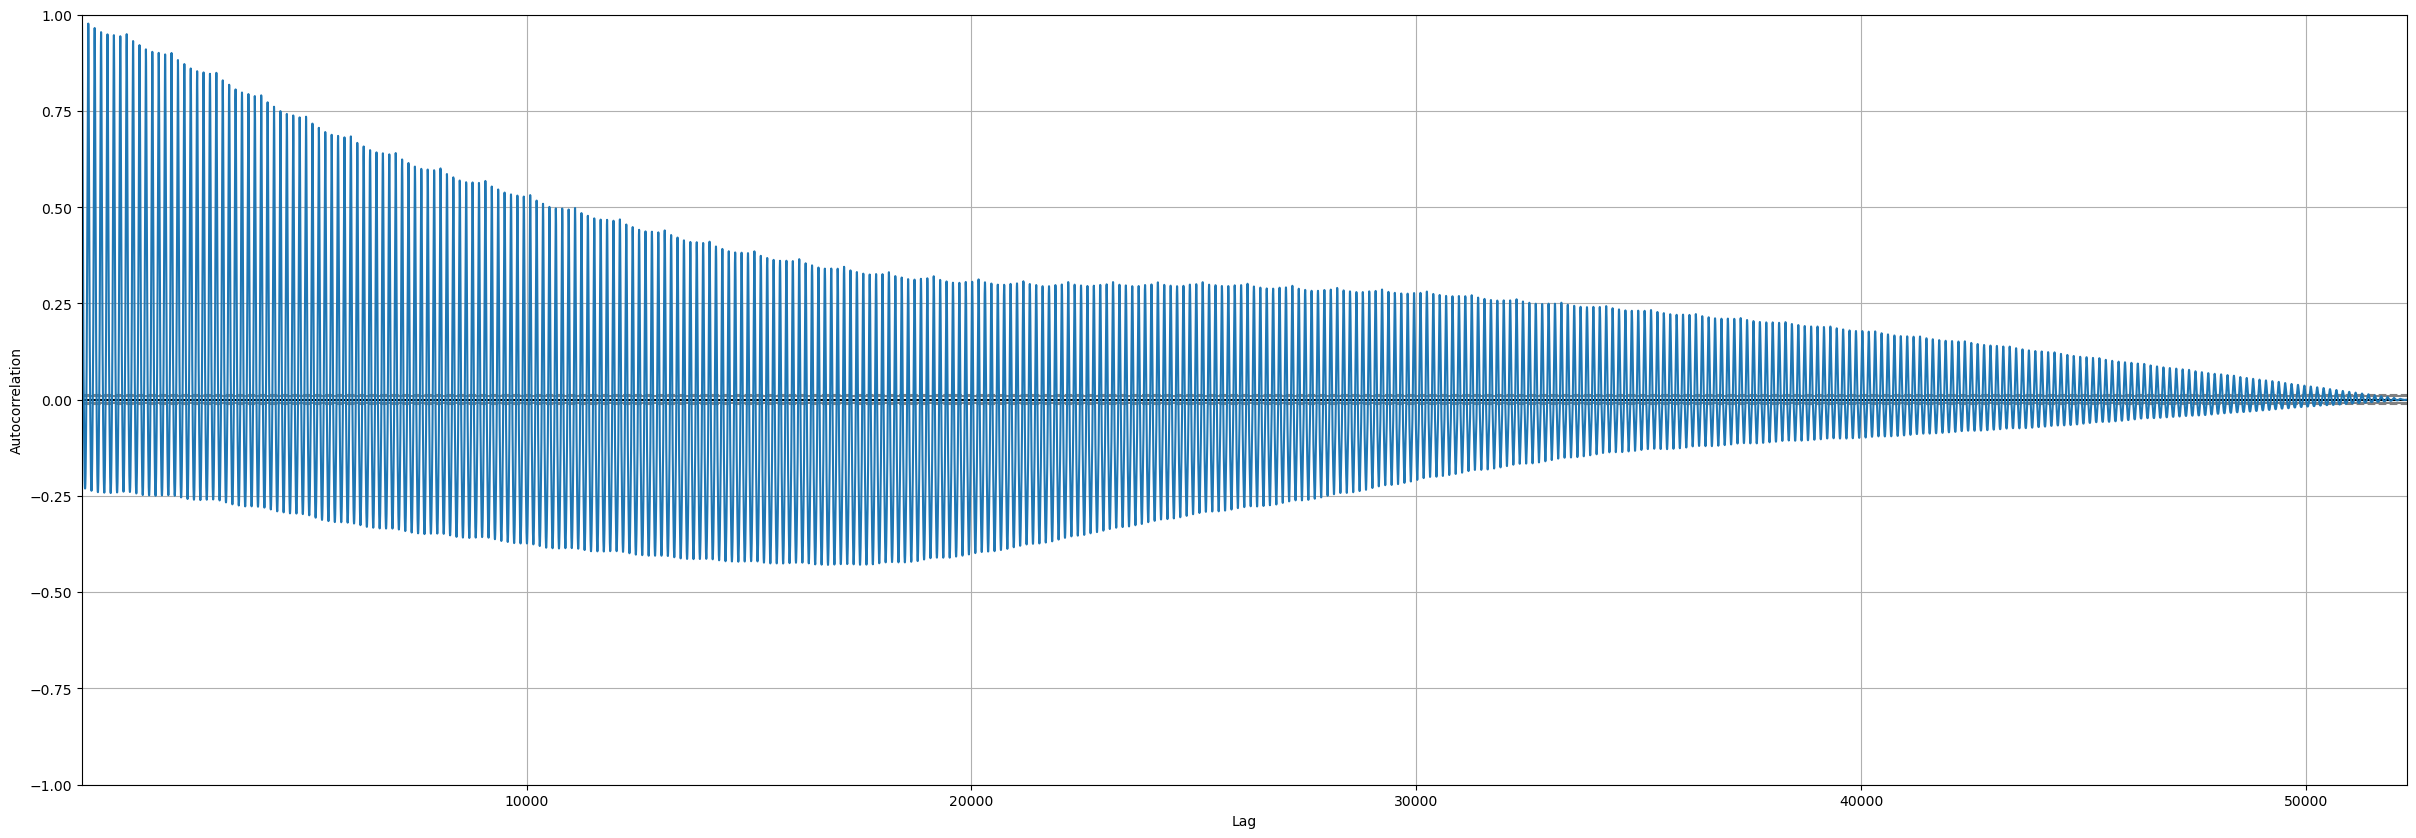

In [12]:
plt.figure(figsize=(30,10))
autocorrelation_plot(train["Total Power Consumption"])
plt.show()

Here we can see that the autocorrelation plot shows maximum autocorrelation at lag zero and gradually decreases over subsequent lags, which suggests a strong immediate dependence between consecutive observations, potentially indicating underlying seasonality or trend components in the data. This indicates the suitability of this data for univariate timeseries forecasting.

### Model Building <a class="anchor" id="8"></a> 

Once the dataset has been divided into the training and testing datasets, we can use the training data for modelling.

#### Data Preprocessing <a class="anchor" id="9"></a> 

In this method, we are using a single variable named Total Power Consumption to forecast the 144 timesteps of future total power consumption or electricity usage for every 10 minutes based on its historical data, without using any explanatory variables.

The pre-processing of the data is carried out by the `prepare_tabulardata` method from the `arcgis.learn` module in the ArcGIS API for Python. This function will take either a non spatial dataframe, a feature layer or a spatial dataframe containing the dataset as input and will return a TabularDataObject that can be fed into the model. Here we are using a non spatial dataframe. 

The primary input parameters required for the tool are:

- <span style='background :lightgrey' >input_features</span> : non spatial dataframe containing the primary dataset 
- <span style='background :lightgrey' >variable_predict</span> : field name `Total Power Consumption` as the y-variable to be forecasted from the input dataframe
- <span style='background :lightgrey' >explanatory_variables</span> : Since there are none in this example, it is not required here. 
- <span style='background :lightgrey' >index_field</span> : field name containing the timestamp

Here, the preprocessor is used for scaling the data to improve the fit of the model.

In [13]:
# one step, univariate
preprocessors = [("Total Power Consumption", MinMaxScaler())] 

data = prepare_tabulardata(train, 
                           variable_predict="Total Power Consumption",
                           index_field="DateTime", 
                           preprocessors=preprocessors)

C:\Users\sup10432\AppData\Local\ESRI\conda\envs\pro3.3_automl_QA_jan24\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



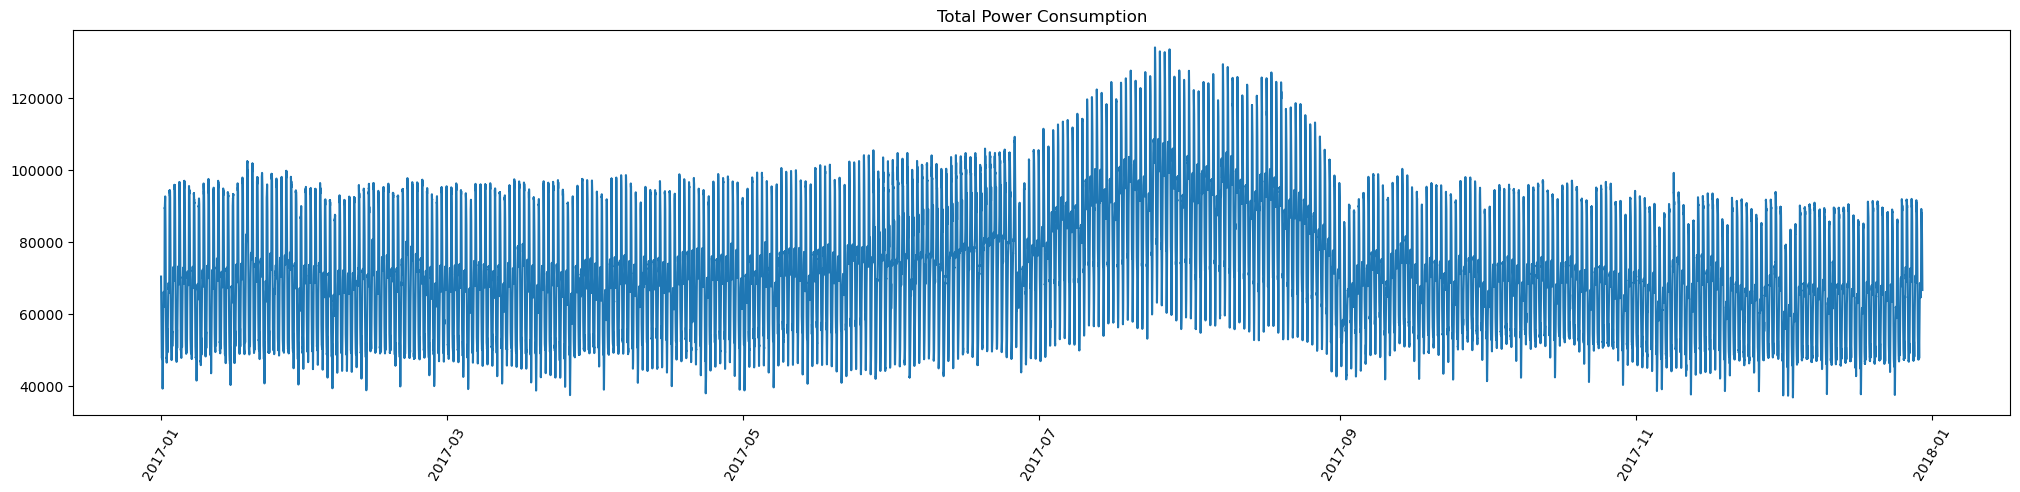

In [14]:
# Visualize the entire timeseries data
data.show_batch(graph=True)

Here we can utilize the show_batch() function both for inspection and visualization. First, we use it to display the Total Power Consumption data, where each time series data instance is identified by an index corresponding to its specific datetime.  

In [15]:
data.show_batch()

Total Power Consumption
19770              53258.85754
28061             116044.38323
33214              91241.08204
34775              76922.19575
50228              86624.92361

Next, the sequence length of 288 is used, as it is the previous two days of power consumption data. This is an important parameter for fitting a timeseries forecasting model and usually indicates the seasonality of the data, which can be experimented with for a better fit. 

Using this sequence length, we can use the `show_batch()` function for visualization. The graph below depicts the segmentation of univariate time series data into batches, where each batch aligns with the specified sequence length designated for the model. The x-axis delineates the data, organized in batches, with each ticker at a 6-day interval. The y-axis represents the absolute values of power consumption. Notably, the value on the top of the graph signifies the target variable for forecasting, denoting the value after the end of the respective sequence lengths. This value serves as the dependent variable during the training of the time series model.

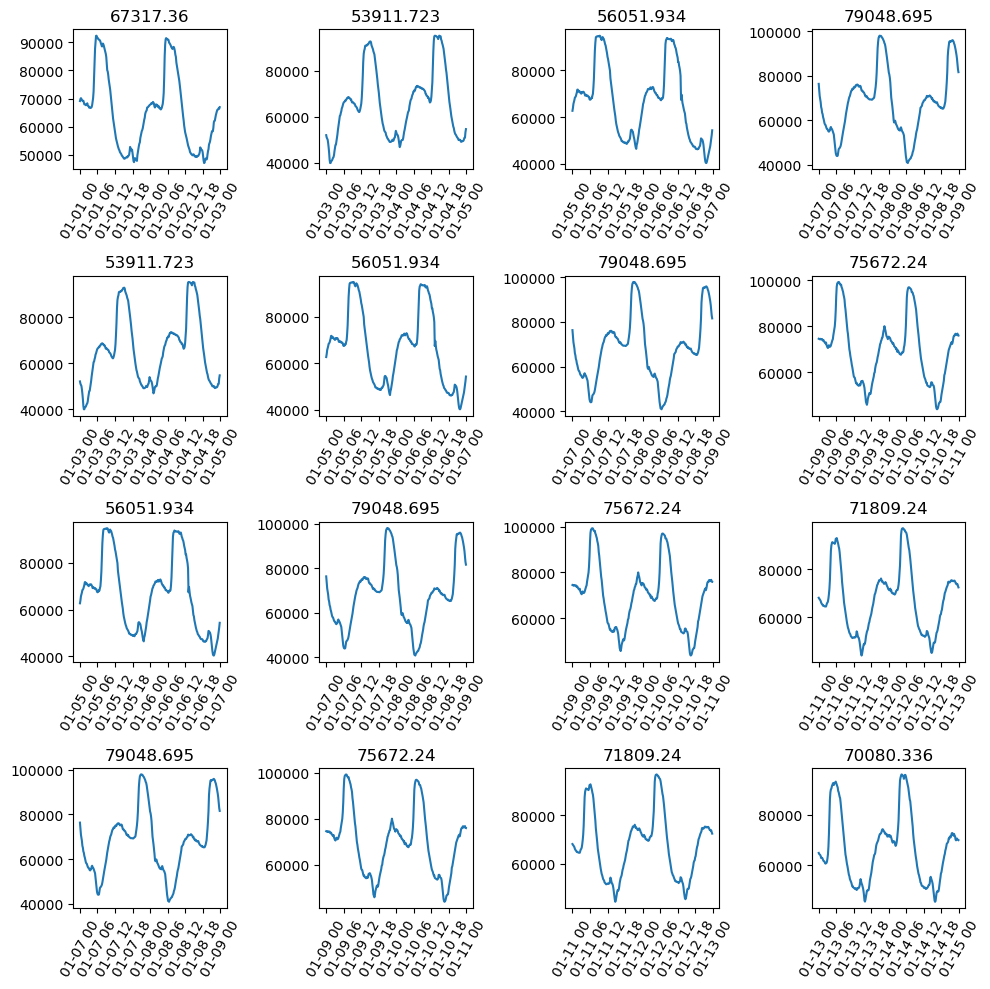

In [16]:
# visualize the timeseries in batches
seq_len = 288
data.show_batch(rows=4,seq_len=seq_len)

#### Model Initialization <a class="anchor" id="10"></a>

This is the most significant step for fitting a timeseries model. Here, along with the pre-procesed data, the backbone for training the model and the sequence length is passed as parameters. Out of these three, the sequence length must be selected carefully since it is a critical parameter. The sequence length is usually the cycle of the data. You can try with higher sequence lengths if there are sufficient computing resources available. 

In terms of backbones, the available set of backbones encompasses various architectures specialized for handling time series data. These include models specifically designed for time series (InceptionTime, TimeSeriesTransformer), recurrent neural networks like LSTM and Bidirectional LSTM, Neural network (FCN), and adaptations of convolutional neural networks (ResNet, ResCNN) for effective time series analysis.

Here we will use the `LSTM Bidirectional` model.

In [17]:
# In model initialization, the data and the backbone is selected 
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='LSTM',bidirectional=True)

#### Learning Rate Search <a class="anchor" id="11"></a>

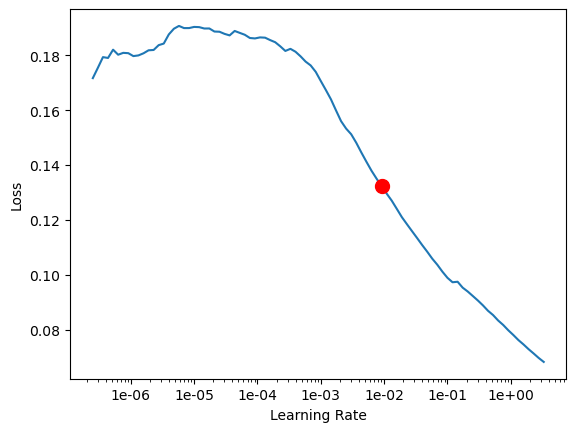

0.009120108393559097

In [18]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()
l_rate

### Model Training <a class="anchor" id="12"></a>

Finally, the model is now ready for training. To train the model, the `model.fit` function is called and provided with the number of epochs for training and the estimated learning rate suggested by  `lr_find` in the previous step. We will use 2 epochs for training, as it was found that 2 epochs are sufficient for the model to converge due to the high quality of the data, the large size of the dataset, and good seasonality in the data. In other cases, we might have to train further and use more epochs:

In [19]:
ts_model.fit(2, lr=l_rate)

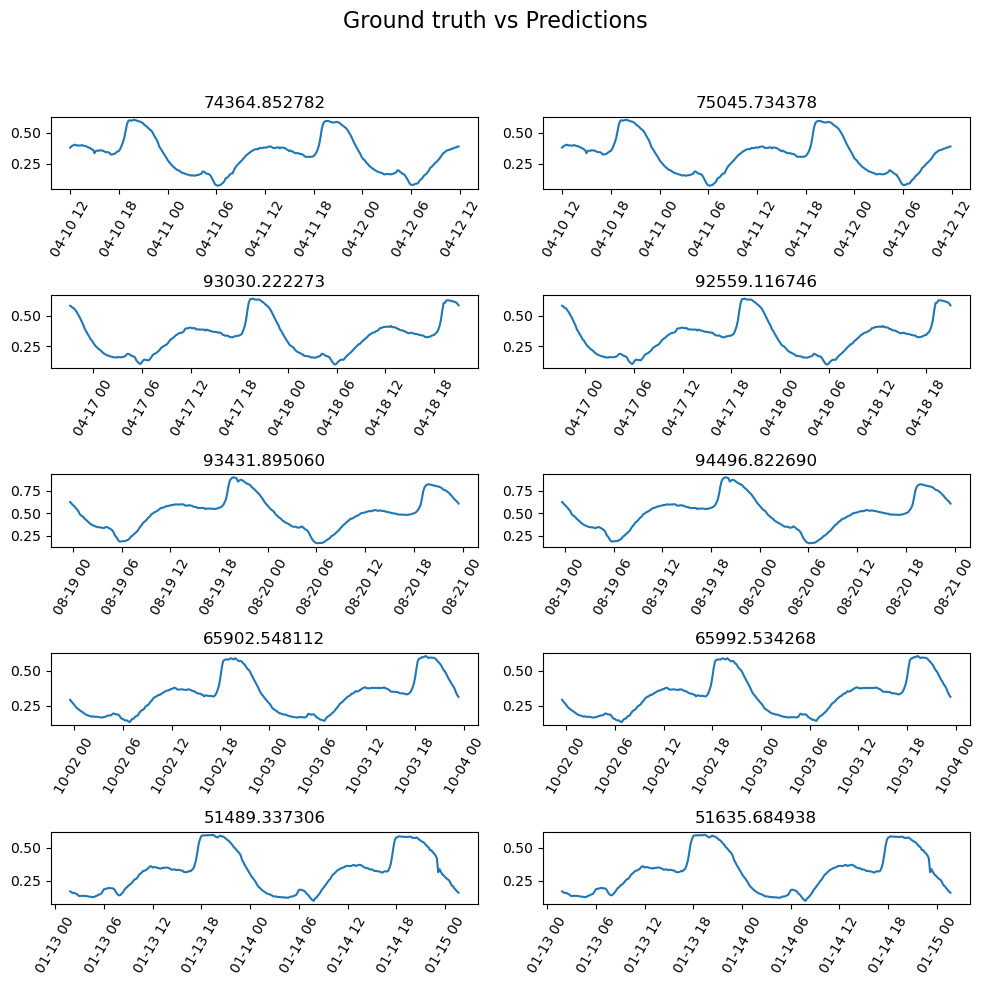

In [20]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

Next, we will use `show result` to compare the actual vs the forecasted value to understand the performance of the model. The value on the top of the left side of the graph signifies the actual target variable for forecasting, denoting the value after the end of the sequence length, whereas the value on the top of the corresponding right side graph signifies the forecasted value by the trained model. The x-axis delineates the data, organized in batches, with each ticker at 6-day interval, and the y-axis represents the normalized values of the power consumption variable. The plot reveals that the ground truths are close to the forecasted values, indicating a good fit. This is further validated by checking the model score. 

In [21]:
# check the trained model score
ts_model.score()

0.9987402371186077

### Power Consumption Forecast & Validation using one-step <a class="anchor" id="13"></a>

#### Forecasting Using the trained Timeseries Model <a class="anchor" id="14"></a>

Once the model is trained, the predict function is used to forecast for a period of the next 144 time steps after the last recorded time step in the training dataset. Here the model utilizes the same training dataset during the forecasting process. Specifically, the model extracts the last set of data points equivalent to the specified sequence length from the trailing portion of the dataset to predict the user-specified number of future data points. So, it will forecast 144 values for  the day of 30th December, at every 10 minutes of power consumption, starting on  00:00, 00:10, 00:20 and so on, till 23:50 of the same day. 

In [22]:
# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'  
sdf_forecasted_univar = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)

In [23]:
# checking the final forecasted result returned by the model
sdf_forecasted_univar.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52414  2017-12-30 23:40          NaN       NaN         NaN   
52415  2017-12-30 23:50          NaN       NaN         NaN   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52414                    NaN            NaN                       NaN   
52415                    NaN            NaN                       NaN   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52414                        NaN                        NaN   
52415                        NaN                        NaN   

       Total Power Consumption Month weekday  hour  \
52414                      NaN   NaN     NaN   NaN   
52415                      NaN   NaN     NaN   NaN   

       Total Power Consumption_results  
52414                     68229.654023  
52415                     66733.589550

#### Estimate model metrics for validation <a class="anchor" id="15"></a>

The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 144 time steps set aside at the beginning.

In [24]:
# Formating the forecasted result into actual vs the predicted columns
sdf_forecasted = sdf_forecasted_univar.tail(test_size).copy()
sdf_forecasted = sdf_forecasted[['DateTime','Total Power Consumption_results']]
sdf_forecasted['Actual_Total Power Consumption'] = test['Total Power Consumption'].values
sdf_forecasted = sdf_forecasted.set_index(sdf_forecasted.columns[0])
sdf_forecasted.head()

Total Power Consumption_results  \
DateTime                                            
2017-12-30 00:00                     65264.373139   
2017-12-30 00:10                     63824.832735   
2017-12-30 00:20                     62416.716206   
2017-12-30 00:30                     61075.375774   
2017-12-30 00:40                     59815.544920   

                  Actual_Total Power Consumption  
DateTime                                          
2017-12-30 00:00                     65061.74921  
2017-12-30 00:10                     63079.20846  
2017-12-30 00:20                     61256.28975  
2017-12-30 00:30                     60136.79086  
2017-12-30 00:40                     58771.21664

In [25]:
sdf_forecasted.shape

(144, 2)

In [26]:
# Bi-LSTM
r2_test = r2_score(sdf_forecasted['Actual_Total Power Consumption'],sdf_forecasted['Total Power Consumption_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.96


A considerably high r-squared value indicates a high similarity between the forecasted and the actual sales values.

### Result Visualization <a class="anchor" id="16"></a>

Finally, for measuring the trained model's performance, the actual and forecasted values are plotted to visualize their distribution over the 144 timesteps. This enables a visual comparison between forecasted and observed data, facilitating a quick assessment of the forecasting model's accuracy.

In [27]:
sdf_forecasted.head(2)

Total Power Consumption_results  \
DateTime                                            
2017-12-30 00:00                     65264.373139   
2017-12-30 00:10                     63824.832735   

                  Actual_Total Power Consumption  
DateTime                                          
2017-12-30 00:00                     65061.74921  
2017-12-30 00:10                     63079.20846

In [28]:
#sdf_forecasted = sdf_forecasted.reset_index()
sdf_forecasted['DateTime'] = (sdf_forecasted.index).to_timestamp()
sdf_forecasted.set_index('DateTime', inplace=True)

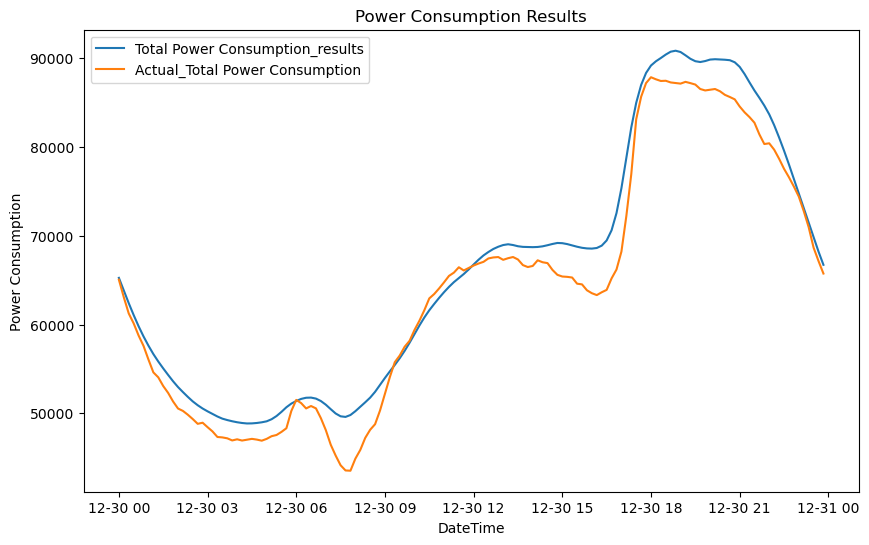

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(sdf_forecasted.index, sdf_forecasted['Total Power Consumption_results'], label='Total Power Consumption_results')
plt.plot(sdf_forecasted.index, sdf_forecasted['Actual_Total Power Consumption'], label='Actual_Total Power Consumption')
plt.xlabel('DateTime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Results')
plt.legend()
plt.show()

The graphs indicate that the forecast is quite impressive, especially considering it's based on a univariate time series spanning 144 future time steps. Let's explore if the model could be further enhanced by incorporating multivariate data and employing additional methods.

## Multi-Step Multivariate Forecasting <a class="anchor" id="17"></a>

Multivariate forecasting involves using multiple time series variables (e.g., historical power consumption, temperature, humidity, etc.) to make predictions. This allows the model to capture more complex relationships and dependencies; however, it can also be more computationally intensive. Multi-Step forecasting methods involve predicting multiple future time steps at once. For instance, forecasting the power consumption for the next several timesteps simultaneously at one go.

Here the Multi-Step Multivariate Forecasting method combines both the multi-step and multivariate approaches, where multiple future time steps are forecasted using a model using multiple explanatory variables.

### Timeseries Data Preparation <a class="anchor" id="18"></a>   
Data preparation for timeseries consists of first splitting the dataset into a training dataset and a testing dataset as follows:

#### Train - Test split of timeseries dataset <a class="anchor" id="19"></a>

As explained earlier, we will set aside the 144 (6 x 24) data points as the test set, while the remaining data will be used for training.

In [30]:
test_size = 144

In [31]:
city_power_consumption_df.shape

(52416, 13)

In [32]:
train, test = train_test_split(city_power_consumption_df, test_size = test_size, shuffle=False)

In [33]:
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  
52270              67976.01881  December  Friday  23.0  
52271              66688.25950  December  Friday  23.0

In [34]:
test.head(2)

DateTime  Temperature  Humidity  Wind Speed  \
52272 2017-12-30 00:00:00        13.17     52.67       0.077   
52273 2017-12-30 00:10:00        13.07     52.67       0.077   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52272                  0.062          0.126               27692.77567   
52273                  0.037          0.111               26792.39544   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52272                24611.23044                 12757.7431   
52273                23874.80822                 12412.0048   

       Total Power Consumption     Month   weekday  hour  
52272              65061.74921  December  Saturday   0.0  
52273              63079.20846  December  Saturday   0.0

In [35]:
train.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'Total Power Consumption', 'Month', 'weekday', 'hour'],
      dtype='object')

### Model Building <a class="anchor" id="20"></a>

Once the dataset is divided into the training and testing datasets, the training data is ready to be used for modelling.

#### Data Preprocessing <a class="anchor" id="21"></a>

Next we will be using the additional multivariate of Temperature, Humidity, Wind Speed, general diffuse flows, and diffuse flows, combined with related datetime information of month, weekday, and hour. Of these, month and weekday are used as categorical variables. As we did earlier, we will forecast the 144 timesteps of future total power consumption or electricity usage for every 10 minutes based on historical data, using these explanatory variables.

The preprocessing of the data is done by the `prepare_tabulardata` method from the arcgis.learn module in the ArcGIS API for Python. 

Here, the additional parameter  `explanatory_variables` will be used along with the parameters used earlier.

This function will take either a non spatial dataframe, a feature layer, or a spatial dataframe containing the dataset as input and will return a TabularDataObject that can be fed into the model. Here we are using a non spatial dataframe.

The additional input parameter required for the tool is:

    explanatory_variables : We will pass the selected multiple variables in a list, along with declaring the relevant categorical variables    

The preprocessor is used for scaling the data, which usually improves the fit of the model.

In [36]:
# multistep multivariate
preprocessors = [("Temperature","Humidity","Wind Speed","general diffuse flows","diffuse flows",
                  "Total Power Consumption", MinMaxScaler())]
data = prepare_tabulardata(train, 
                           variable_predict="Total Power Consumption",                           
                           explanatory_variables=["Temperature","Humidity","Wind Speed",
                                                  "general diffuse flows","diffuse flows",('Month',True),
                                                  ('weekday',True), 'hour'],
                           index_field="DateTime", preprocessors=preprocessors)

C:\Users\sup10432\AppData\Local\ESRI\conda\envs\pro3.3_automl_QA_jan24\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



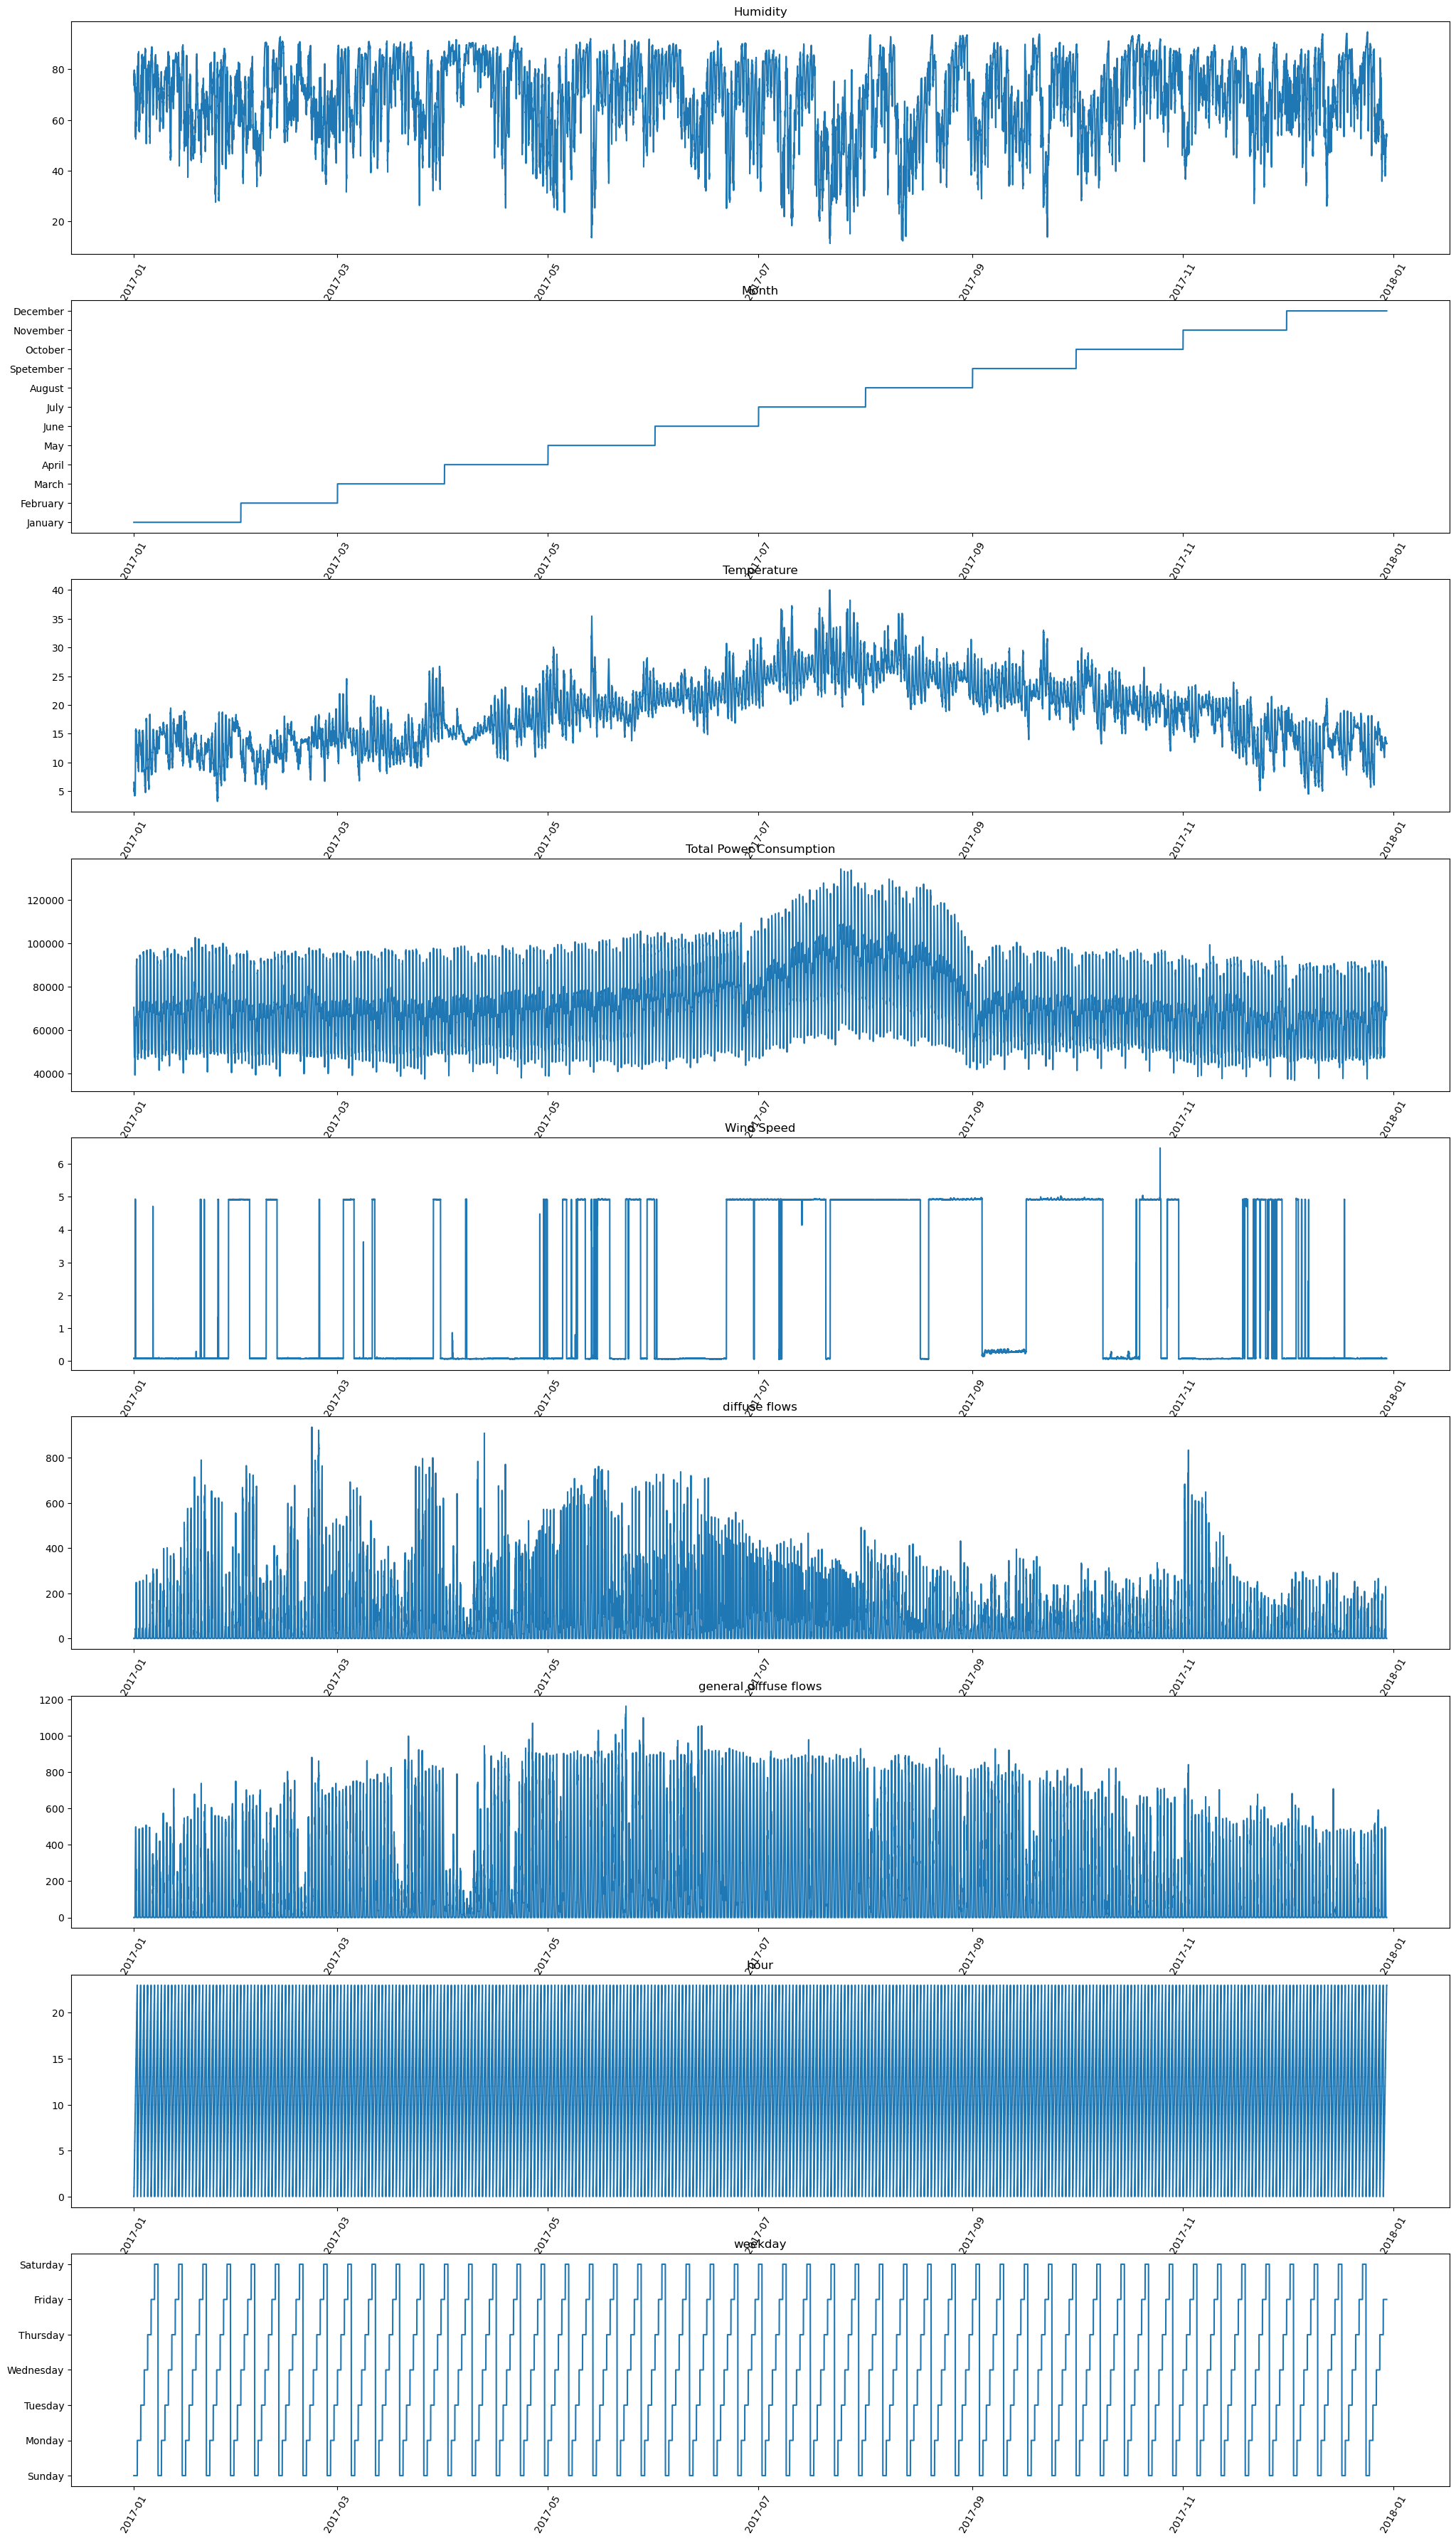

In [37]:
# Visualize the data distibution of all the variables 
data.show_batch(graph=True)

In [38]:
data.show_batch()

Humidity     Month  Temperature  Total Power Consumption  Wind Speed  \
19770      78.8       May        18.86              53258.85754       4.916   
28061      77.2      July        25.66             116044.38323       4.913   
33214      71.8    August        27.75              91241.08204       4.923   
34775      81.0    August        27.23              76922.19575       4.920   
50228      70.6  December        15.00              86624.92361       0.082   

       diffuse flows  general diffuse flows  hour    weekday  
19770         85.300                 94.800   7.0   Thursday  
28061          0.207                  0.234  20.0     Friday  
33214        163.800                700.000  15.0   Saturday  
34775        244.300                398.200  11.0  Wednesday  
50228          0.145                  0.051  19.0     Friday

The sequence length used is 288, the same as earlier, which is the previous two days of power consumption data.

As explained earlier, with this sequence length, we use the `show_batch()` function for visualization. However, for multivariate modeling, the `show_batch` function is currently experimental, so only the graph of the forecasting variable (blue) is appropriate, and you can ignore the explanatory variable graphs, which will be updated soon. Notably, the value on the top of the graph signifies the target variable for forecasting, denoting the value after the end of the respective sequence lengths. This value serves as the dependent variable during the training of the time series model.

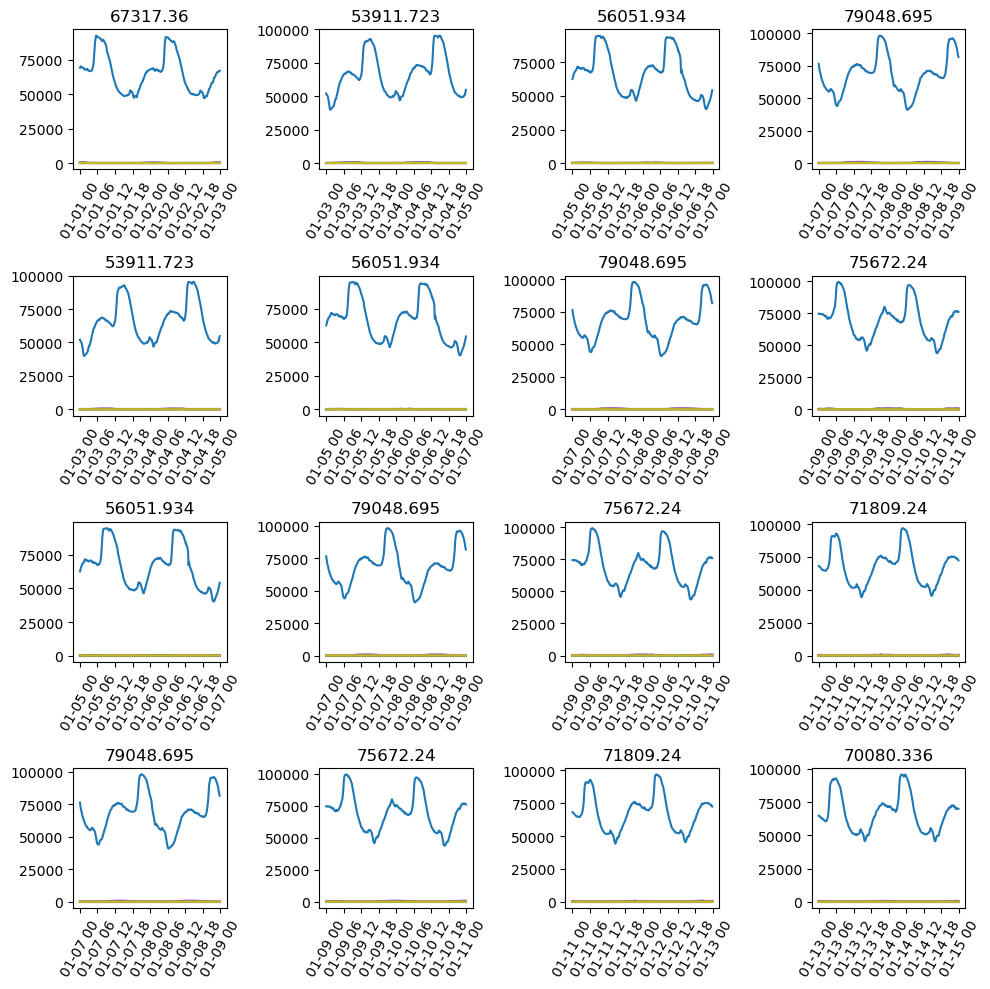

In [39]:
# half of seq len to be predicted, so if the test size is 144, then 288 should be seq len
seq_len = 288
data.show_batch(rows=4,seq_len=seq_len)

#### Multi-step Model Initialization <a class="anchor" id="22"></a>

Along with the sequence length and model architecture parameters we used earlier, we will also pass the additional parameter of `multistep=True` for initializing the model. For the model architecture, we will use `InceptionTime` which is a backbone specifically designed for time series.

In [40]:
# multistep
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='InceptionTime',multistep=True)

#### Learning Rate Search <a class="anchor" id="23"></a>

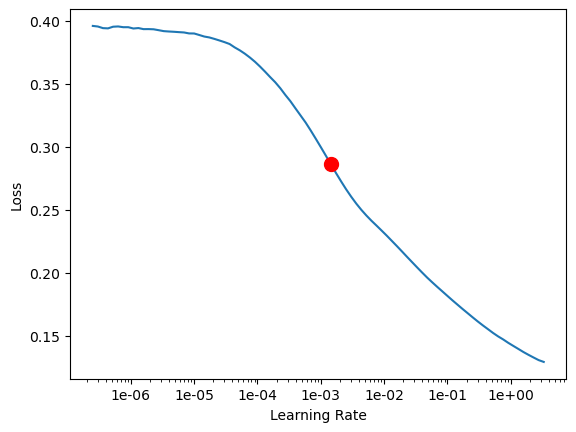

0.001445439770745928

In [41]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()
l_rate

### Model Training <a class="anchor" id="24"></a>

Finally, the model is now ready for training. To train the model, the model.fit method is called and provided with the number of epochs for training and the estimated learning rate suggested by `lr_find` in the previous step. As earlier, we will train it for two epochs.

In [42]:
ts_model.fit(2, lr=l_rate)

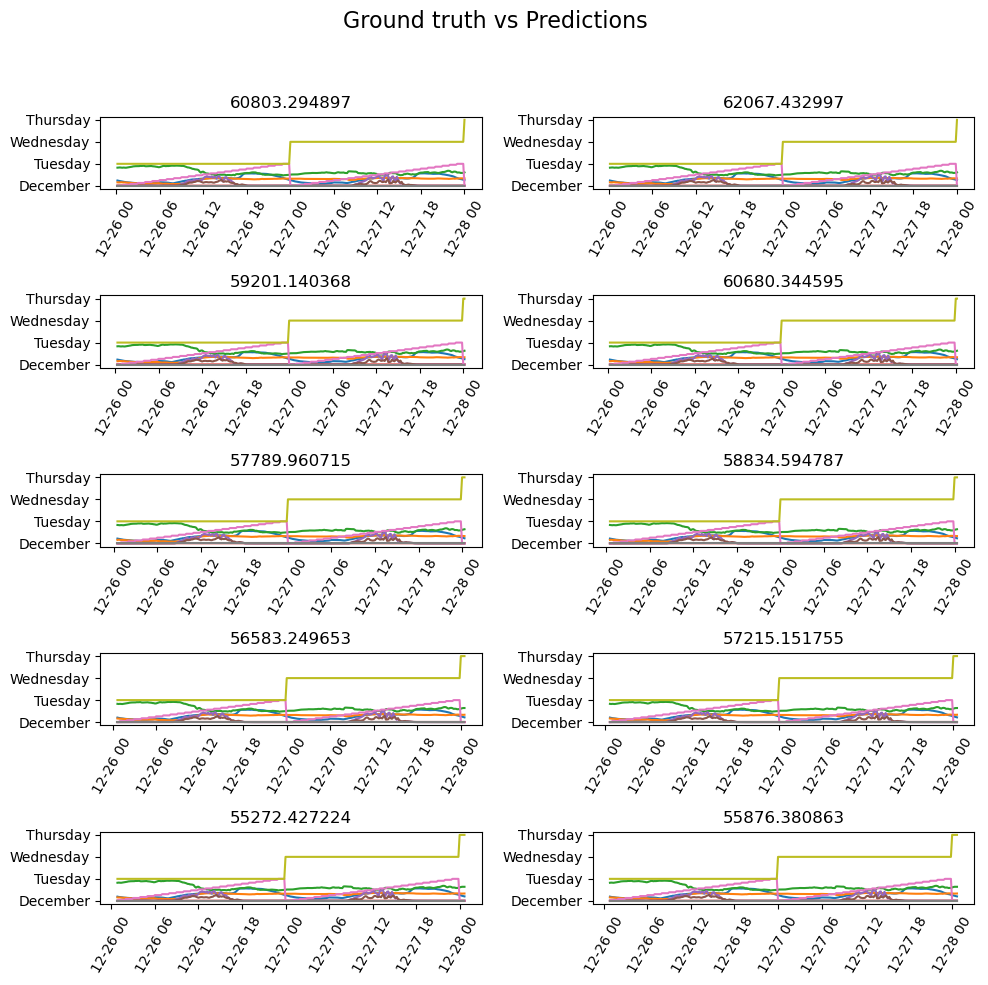

In [43]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

Next `show_result` is used to visualize and compare the actual vs the forecasted values to understand the model's performance. However, for multivariate modeling, the `show_result` function is currently experimental. Therefore, only the values displayed at the top of the graphs are appropriate, while the graphs themselves can be disregarded. They will be updated soon. The value on the top of the left column graphs signifies the actual target variable for forecasting, denoting the value after the end of the sequence length, whereas the value on the top of the corresponding right column graphs signifies the forecasted value by the trained model. The x-axis delineates the data, organized in batches, with each ticker at 6-day interval. The plot reveals that the ground truths are considerably close to the forecasted values, indicating a good fit. This is further validated by checking the model score. 

In [44]:
ts_model.score()

0.9726143454636047

### Power Consumption Forecast & Validation using Multi-Step multivariate<a class="anchor" id="25"></a>

#### Forecasting Using the trained Timeseries Model <a class="anchor" id="26"></a>

Once the model is trained, the `predict` function is used to forecast for a period of the next 144 time steps after the last recorded time steps in the training dataset. In cases of multi-step forecasting, we do not need to specify the number of future timesteps to forecast, and the predict function will automatically predict half of the sequence length used while preprocessing the data. The sequence length should be chosen with this in mind

Here, the model utilizes the same training dataset during the forecasting process and will use the last set of data points equivalent to the specified sequence length from the tail to predict future data points. So, it will forecast for the day of December 30th, at every 10 minutes of power consumption, starting on 00:00, 00:10, 00:20, etc., until 23:50 of the same day. 

In [45]:
# multistep - half of sequence length will be forecasted and the it is returned as a dataframe
sdf_forecasted = ts_model.predict(train,prediction_type='dataframe')

In [46]:
sdf_forecasted.tail()

DateTime  Temperature  Humidity  Wind Speed  \
52411  2017-12-30 23:10          NaN       NaN         NaN   
52412  2017-12-30 23:20          NaN       NaN         NaN   
52413  2017-12-30 23:30          NaN       NaN         NaN   
52414  2017-12-30 23:40          NaN       NaN         NaN   
52415  2017-12-30 23:50          NaN       NaN         NaN   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52411                    NaN            NaN                       NaN   
52412                    NaN            NaN                       NaN   
52413                    NaN            NaN                       NaN   
52414                    NaN            NaN                       NaN   
52415                    NaN            NaN                       NaN   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52411                        NaN                        NaN   
52412                        NaN                        NaN   
52413                        NaN                        NaN   
52414                        NaN                        NaN   
52415                        NaN                        NaN   

       Total Power Consumption Month weekday  hour  \
52411                      NaN   NaN     NaN   NaN   
52412                      NaN   NaN     NaN   NaN   
52413                      NaN   NaN     NaN   NaN   
52414                      NaN   NaN     NaN   NaN   
52415                      NaN   NaN     NaN   NaN   

       Total Power Consumption_results  
52411                     70913.327861  
52412                     70036.664752  
52413                     68180.983745  
52414                     66850.461512  
52415                     63218.897502

In [47]:
sdf_forecasted.shape

(52416, 14)

In [48]:
train.shape

(52272, 13)

In [49]:
test.shape

(144, 13)

In [50]:
test.tail()

DateTime  Temperature  Humidity  Wind Speed  \
52411 2017-12-30 23:10:00        7.010      72.4       0.080   
52412 2017-12-30 23:20:00        6.947      72.6       0.082   
52413 2017-12-30 23:30:00        6.900      72.8       0.086   
52414 2017-12-30 23:40:00        6.758      73.0       0.080   
52415 2017-12-30 23:50:00        6.580      74.1       0.081   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52411                  0.040          0.096               31160.45627   
52412                  0.051          0.093               30430.41825   
52413                  0.084          0.074               29590.87452   
52414                  0.066          0.089               28958.17490   
52415                  0.062          0.111               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52411                26857.31820                14780.31212   
52412                26124.57809                14428.81152   
52413                25277.69254                13806.48259   
52414                24692.23688                13512.60504   
52415                24055.23167                13345.49820   

       Total Power Consumption     Month   weekday  hour  
52411              72798.08659  December  Saturday  23.0  
52412              70983.80786  December  Saturday  23.0  
52413              68675.04965  December  Saturday  23.0  
52414              67163.01682  December  Saturday  23.0  
52415              65750.53976  December  Saturday  23.0

#### Estimate model metrics for validation <a class="anchor" id="27"></a>

The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 144 time steps set aside at the beginning.

In [51]:
sdf_forecasted_slice_test = sdf_forecasted.tail(test_size).copy()
sdf_forecasted_slice_test = sdf_forecasted_slice_test[['DateTime','Total Power Consumption_results']]
sdf_forecasted_slice_test['DateTime'] = pd.to_datetime(sdf_forecasted_slice_test['DateTime'].astype(str))
sdf_forecasted_slice_test['DateTime'] = pd.to_datetime(sdf_forecasted_slice_test['DateTime'])
sdf_forecasted_slice_test.tail(2)

DateTime  Total Power Consumption_results
52414 2017-12-30 23:40:00                     66850.461512
52415 2017-12-30 23:50:00                     63218.897502

In [52]:
sdf_forecasted_slice_test.shape

(144, 2)

In [53]:
sdf_forecasted_slice_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 52272 to 52415
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DateTime                         144 non-null    datetime64[ns]
 1   Total Power Consumption_results  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [54]:
new_forecast = test[['Total Power Consumption','DateTime']]
new_forecast.tail(2)

Total Power Consumption            DateTime
52414              67163.01682 2017-12-30 23:40:00
52415              65750.53976 2017-12-30 23:50:00

In [55]:
df_merge = pd.merge(sdf_forecasted_slice_test, new_forecast)
df_merge.head(5)

DateTime  Total Power Consumption_results  \
0 2017-12-30 00:00:00                     63282.276581   
1 2017-12-30 00:10:00                     62549.594804   
2 2017-12-30 00:20:00                     61420.434485   
3 2017-12-30 00:30:00                     59806.534110   
4 2017-12-30 00:40:00                     56842.927056   

   Total Power Consumption  
0              65061.74921  
1              63079.20846  
2              61256.28975  
3              60136.79086  
4              58771.21664

In [56]:
# bi-lstm
r2_test = r2_score(df_merge['Total Power Consumption'],df_merge['Total Power Consumption_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.97


The r-squared value has improved compared to the one step univariate method.

## One- step multivariate Forecasting <a class="anchor" id="29"></a>

Finally, we will try one more method of multivariate forecasting but with one step instead of multistep, to see if this method performs better than the multi-step forecasting, while using multiple variables.

This combines both the one-step and multivariate approaches, which involves predicting a single timestep in future in a time series, but instead of using just one variable's historical data, we will consider the multiple variables as used in the previous step. This means that it considers the past values of several different factors of temperature, humidity, wind speed etc., when making a single-step prediction. As suggested earlier, a multivariate approach is useful when there are multiple variables that may collectively influence the future value being predicted.

### Timeseries Data Preparation <a class="anchor" id="30"></a>   
Data preparation for timeseries consists of first formatting the input dataframe to be used for forecasting using a One step Multivariate model, followed by splitting the dataset into training and testing datasets.

#### Formatting the input dataframe <a class="anchor" id="31"></a>  

For the input dataframe to be used in forecasting, using the trained one-step multivariate forecasting model, it must be formatted appropriately. For this dataframe, we need to fill the to-be-forecasted variable with NaN values for the number of timesteps to be predicted. Additionally, the corresponding multivariate data for those future timesteps should be present for forecasting.

In [57]:
# Formatting input dataframe to be used for forecasting uisng One step Multivariate
city_power_consumption_df['pred_Total Power Consumption'] = city_power_consumption_df['Total Power Consumption']
city_power_consumption_df.iloc[-test_size:, city_power_consumption_df.columns.get_loc('pred_Total Power Consumption')] = np.nan

#### Train - Test split of timeseries dataset <a class="anchor" id="32"></a>

First, we will set aside the 144 (6 x 24) data points as the test set, while the remaining data will be used for training. Here the training data will be the same as earlier; however, the test data will have NaN values for the forecast variable.

In [58]:
train, test = train_test_split(city_power_consumption_df, test_size = test_size, shuffle=False)

In [59]:
# visualize the train data
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  \
52270              67976.01881  December  Friday  23.0   
52271              66688.25950  December  Friday  23.0   

       pred_Total Power Consumption  
52270                   67976.01881  
52271                   66688.25950

In [60]:
train.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption',
       'Total Power Consumption', 'Month', 'weekday', 'hour',
       'pred_Total Power Consumption'],
      dtype='object')

In [61]:
# visualize the test data
test.head(2)

DateTime  Temperature  Humidity  Wind Speed  \
52272 2017-12-30 00:00:00        13.17     52.67       0.077   
52273 2017-12-30 00:10:00        13.07     52.67       0.077   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52272                  0.062          0.126               27692.77567   
52273                  0.037          0.111               26792.39544   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52272                24611.23044                 12757.7431   
52273                23874.80822                 12412.0048   

       Total Power Consumption     Month   weekday  hour  \
52272              65061.74921  December  Saturday   0.0   
52273              63079.20846  December  Saturday   0.0   

       pred_Total Power Consumption  
52272                           NaN  
52273                           NaN

We can see the test data that we will use in the predict function for forecasting has the forecast variable filled with NaN values, with the corresponding multivariate for the future timesteps.

### Model Building <a class="anchor" id="33"></a>

Once the dataset is divided into the training and test datasets, the training data is ready to be used for modeling.

#### Data Preprocessing <a class="anchor" id="34"></a>

Here we will be using the same additional multivariate as used before, with month and weekday as categorical variables. And as earlier we will forecast the 144 timesteps of future electricity usage for every 10 minutes using these explanatory variables.

In [62]:
# one step multivariate
preprocessors = [("Temperature","Humidity","Wind Speed","general diffuse flows","diffuse flows", 
                  'hour',"pred_Total Power Consumption", MinMaxScaler())]

data = prepare_tabulardata(train, variable_predict="pred_Total Power Consumption",                            
                           explanatory_variables=["Temperature","Humidity","Wind Speed", "general diffuse flows",
                                                  "diffuse flows", ('Month',True), ('weekday',True),"hour"],
                           index_field="DateTime", preprocessors=preprocessors)

C:\Users\sup10432\AppData\Local\ESRI\conda\envs\pro3.3_automl_QA_jan24\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



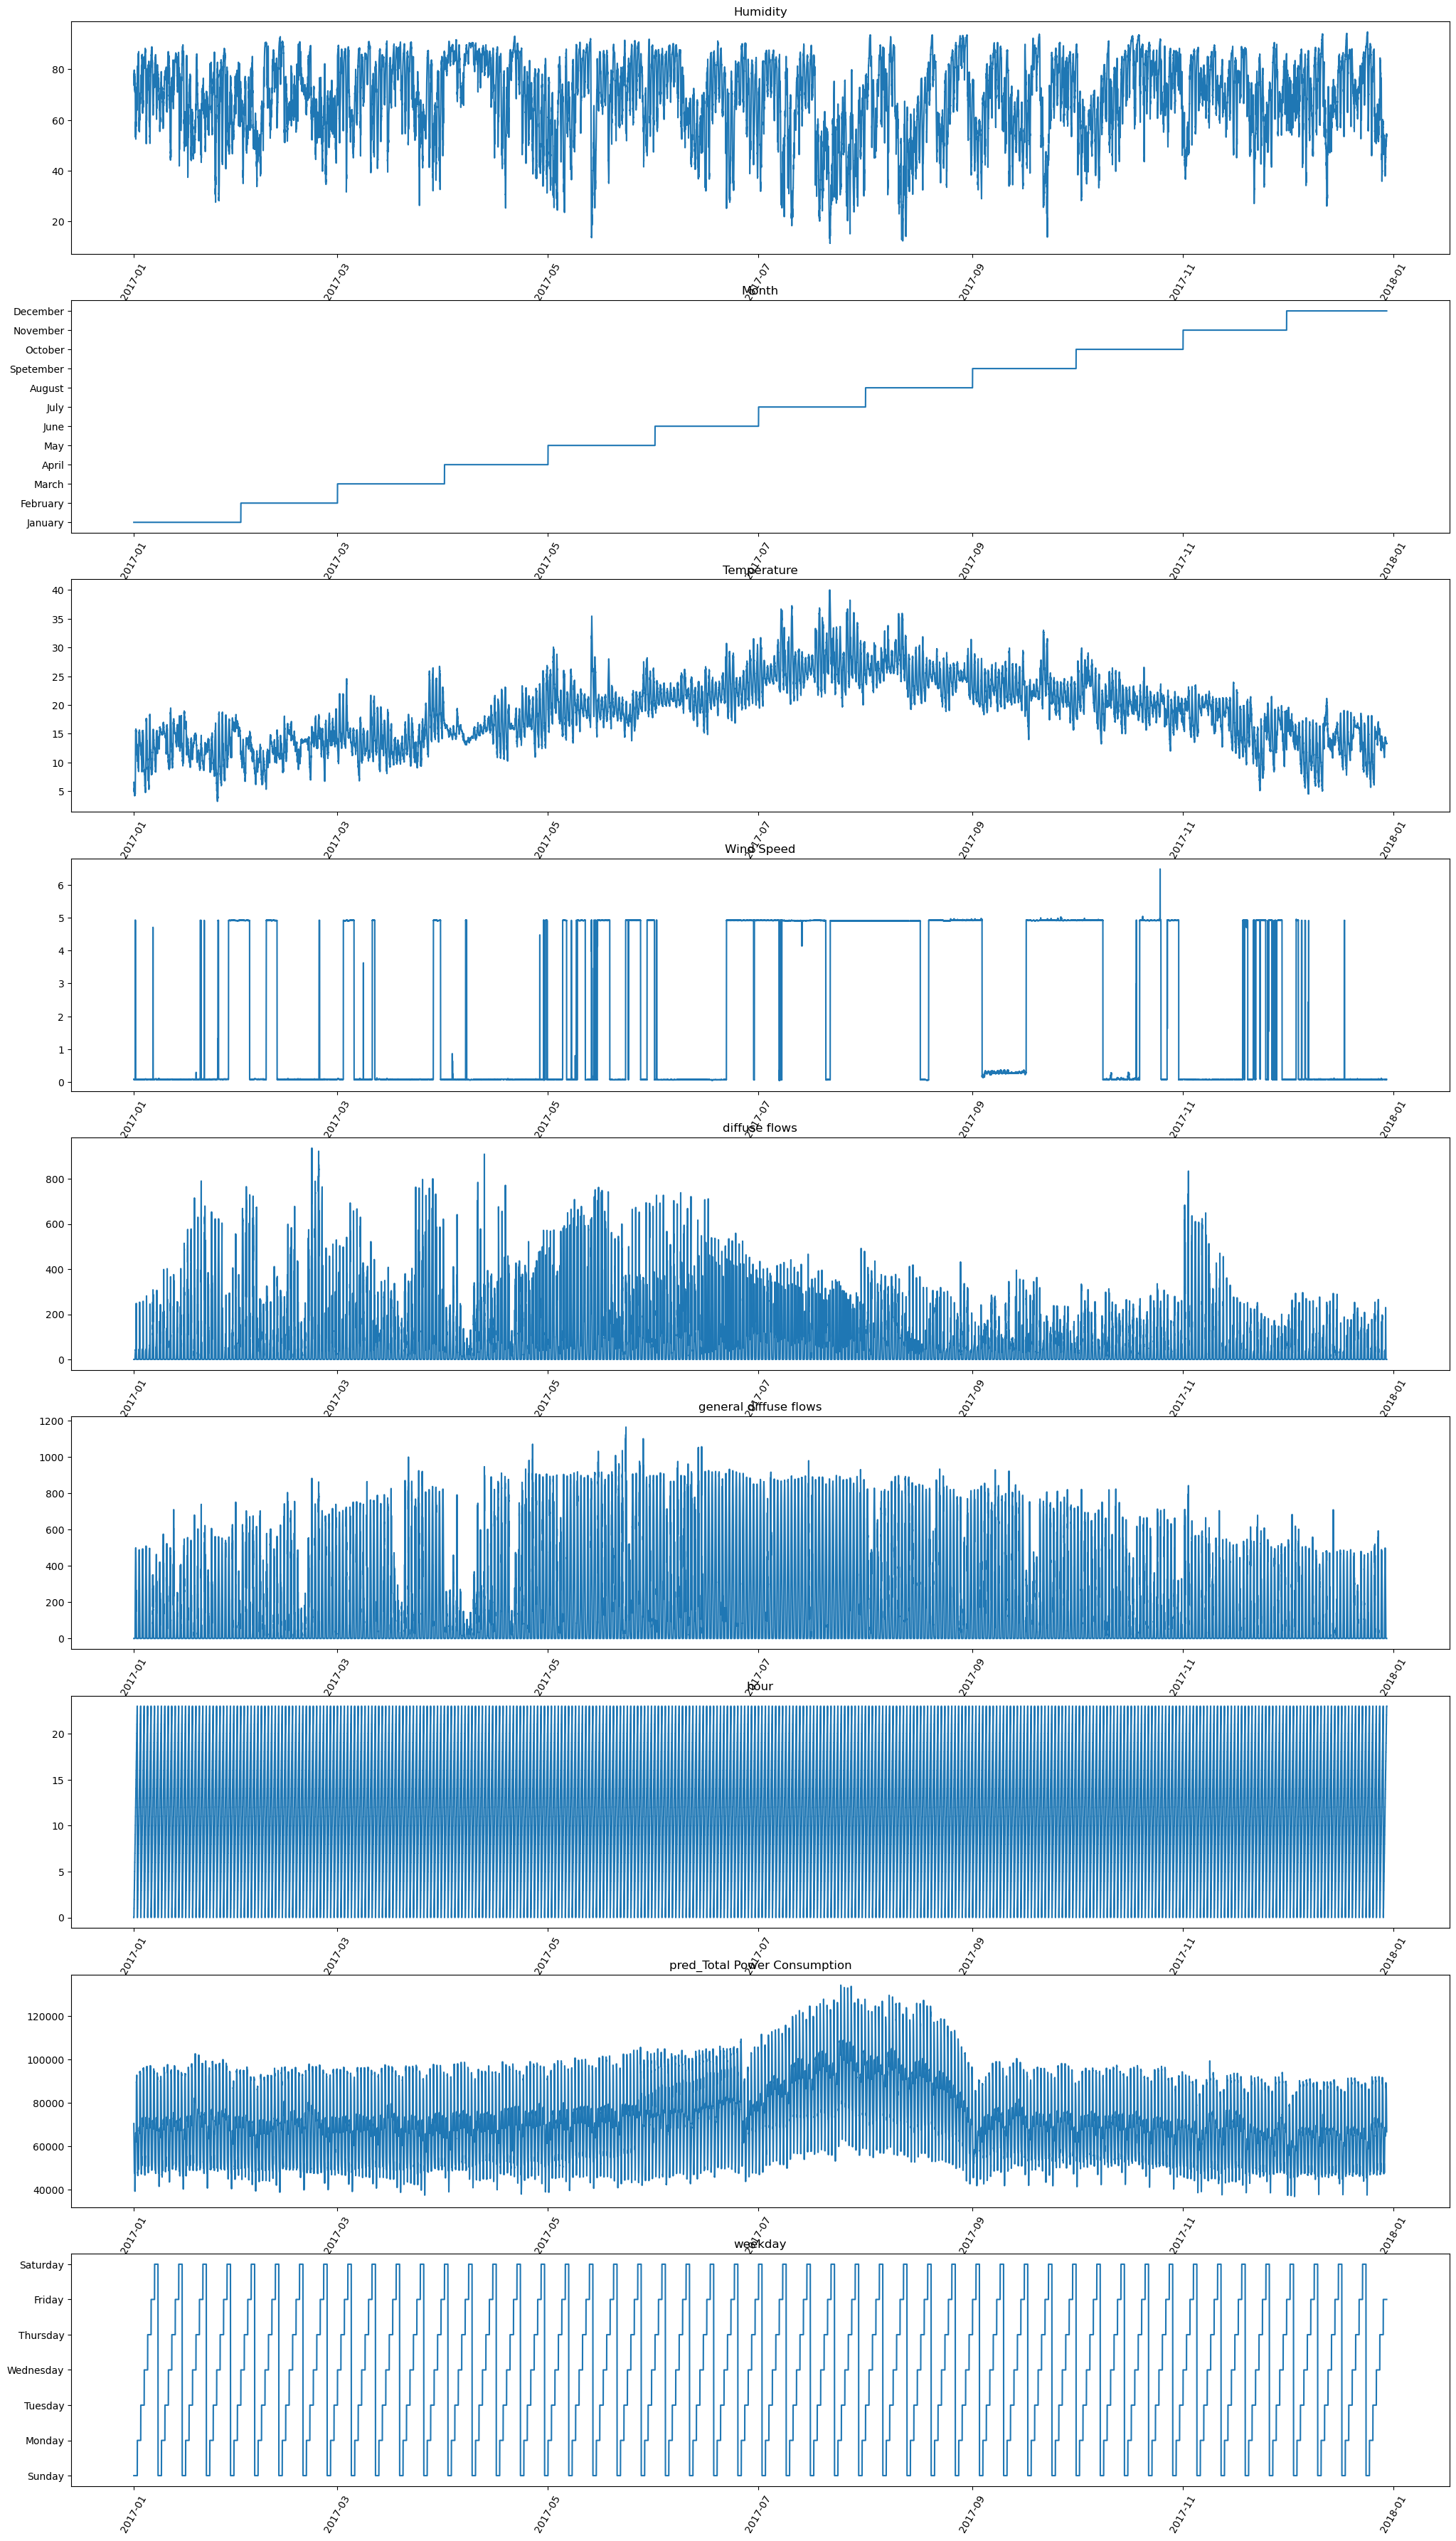

In [63]:
# Visualize the data distibution of all the variables
data.show_batch(graph=True)

In [64]:
data.show_batch()

Humidity     Month  Temperature  Wind Speed  diffuse flows  \
19770      78.8       May        18.86       4.916         85.300   
28061      77.2      July        25.66       4.913          0.207   
33214      71.8    August        27.75       4.923        163.800   
34775      81.0    August        27.23       4.920        244.300   
50228      70.6  December        15.00       0.082          0.145   

       general diffuse flows  hour  pred_Total Power Consumption    weekday  
19770                 94.800   7.0                   53258.85754   Thursday  
28061                  0.234  20.0                  116044.38323     Friday  
33214                700.000  15.0                   91241.08204   Saturday  
34775                398.200  11.0                   76922.19575  Wednesday  
50228                  0.051  19.0                   86624.92361     Friday

Using this sequence length, we use the `show_batch()` function for visualization. As suggested earlier, here only the graph of the forecasting variable (blue) is appropriate, and you can ignore the explanatory variable graphs.

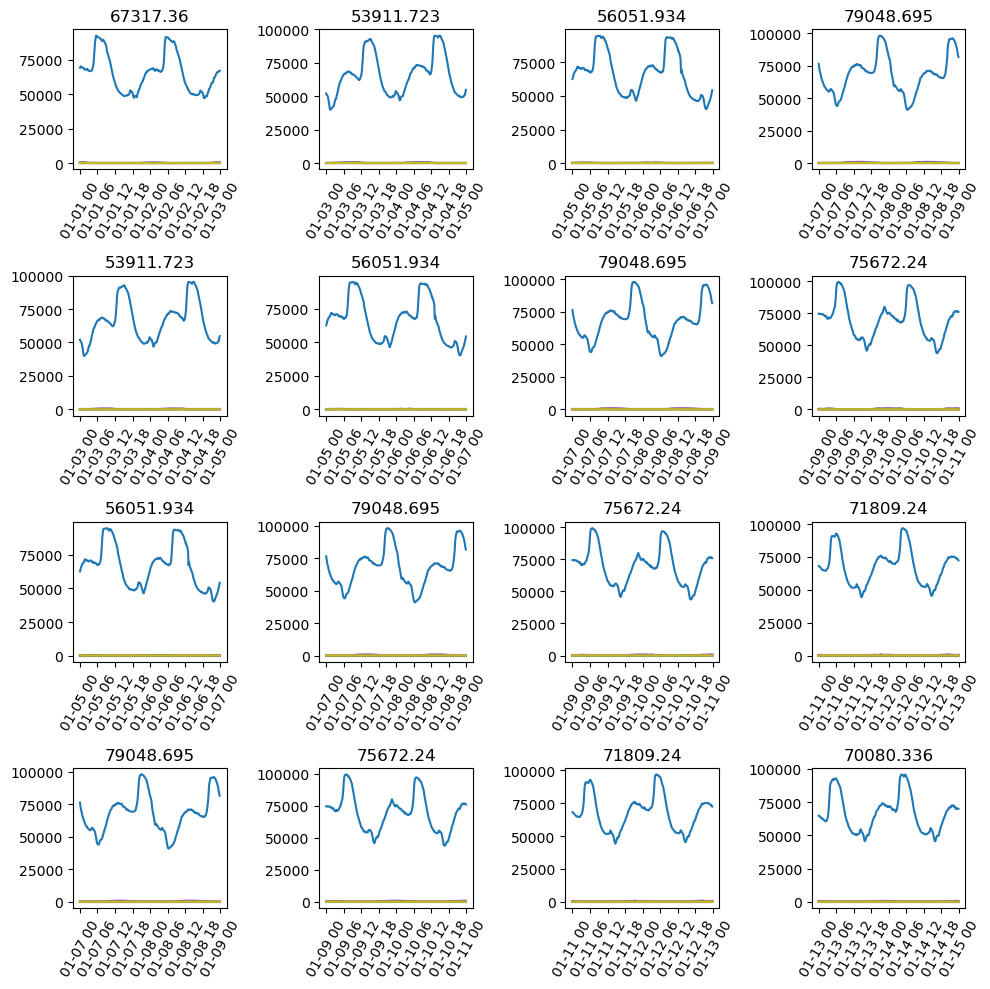

In [65]:
seq_len = 288
data.show_batch(rows=4,seq_len=seq_len)

#### One-step multivariate model initialization <a class="anchor" id="35"></a>

Next, we will initialize a one-step model with the input parameter of data, sequence length, and model architecture. For the model architecture, we will use `InceptionTime` which is a specifically designed backbone for time series. Users can experiment with the various options available. The difference here is in the preparation of the data, which has the multivariate.

In [66]:
# one step - multivariate
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='InceptionTime')

#### Learning Rate Search <a class="anchor" id="36"></a>

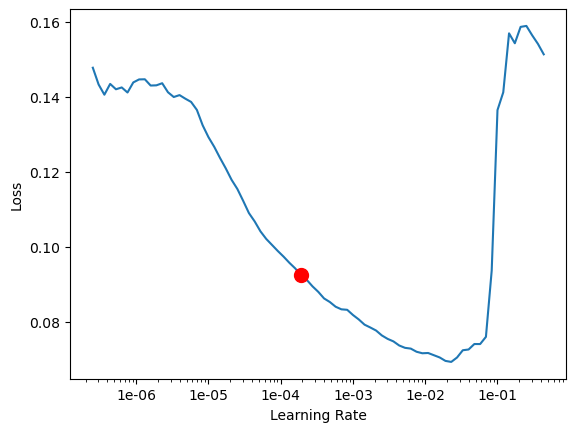

0.00019054607179632462

In [67]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()
l_rate

### Model Training <a class="anchor" id="37"></a>

Finally, we will train the model using `model.fit`, providing the number of epochs and the estimated learning rate suggested by `lr_find` in the previous step. As previously, we will train it for two epochs.

In [68]:
ts_model.fit(2, lr=l_rate)

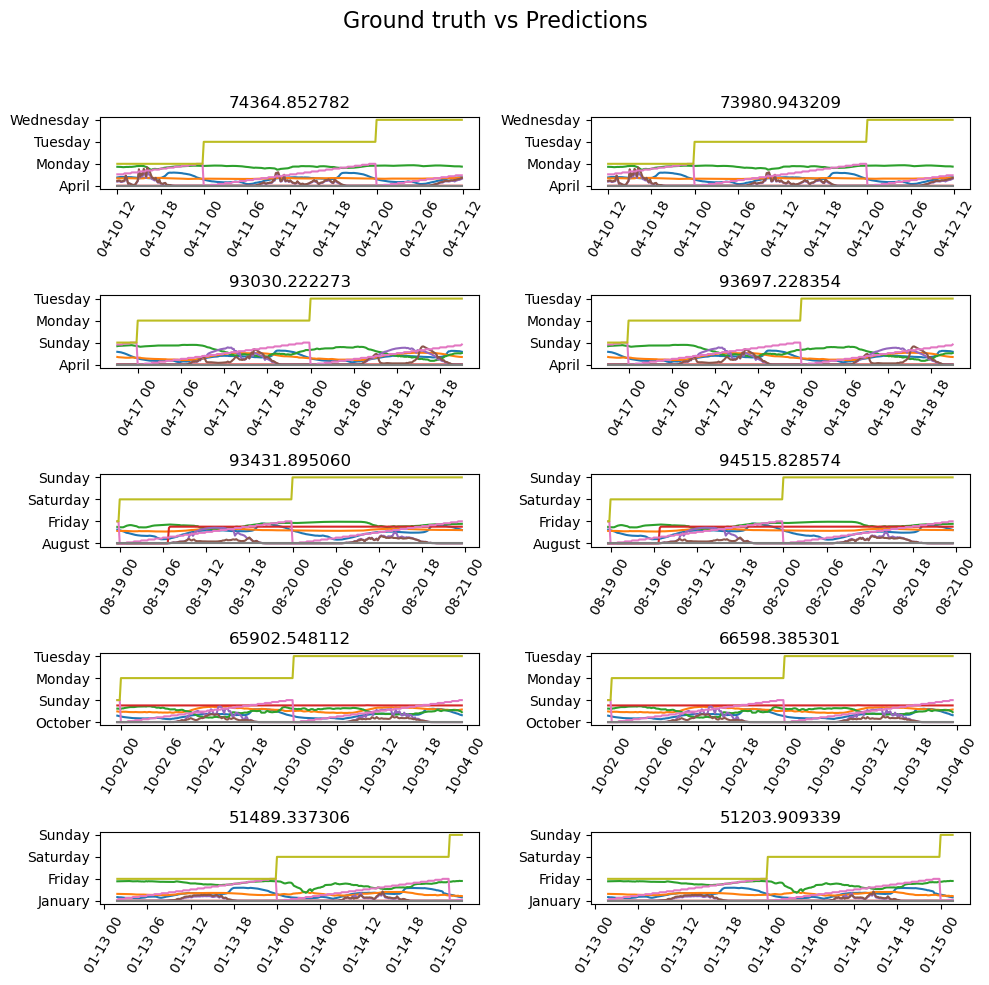

In [69]:
# the ground truth vs the predicted values by the trained model is visualized to check the quality of the trained model
ts_model.show_results(rows=5)

`show_results` is used to visualize and compare the actual vs the forecasted value. This function is experimental and only the values on the top of the graphs are appropriate; you can ignore the graphs. We can see the ground truths are close to the forecasted values by the trained model, indicating a good fit. This is further validated by checking the model score.

In [70]:
ts_model.score()

0.9838986613728246

## Power Consumption Forecast & Validation using One-Step Multivariate <a class="anchor" id="38"></a>

#### Forecasting Using the trained Timeseries Model <a class="anchor" id="39"></a>

The `predict` function is used again to forecast for a period of the next 144 time steps after the last recorded time steps in the training dataset. In the predict function, we need to input the dataset that we prepared earlier, with the to be forecasted rows set to NaN. With these NaN values, we do not need to specify the number of time steps to forecast, as it will automatically forecast for the NaN filled rows. It will forecast for the day of December 30th, at every 10 minutes of power consumption, starting on 00:00, 00:10, 00:20, etc., until 23:50 of the same day.

In [71]:
# forecasted values is returned as a dataframe
sdf_forecasted = ts_model.predict(city_power_consumption_df, prediction_type='dataframe')

In [72]:
train.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52270 2017-12-29 23:40:00        13.27     53.81       0.077   
52271 2017-12-29 23:50:00        13.27     53.74       0.079   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52270                  0.055          0.093               29067.68061   
52271                  0.059          0.063               28544.48669   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52270                25701.13532                13207.20288   
52271                25126.72599                13017.04682   

       Total Power Consumption     Month weekday  hour  \
52270              67976.01881  December  Friday  23.0   
52271              66688.25950  December  Friday  23.0   

       pred_Total Power Consumption  
52270                   67976.01881  
52271                   66688.25950

In [73]:
sdf_forecasted.tail(2)

DateTime  Temperature  Humidity  Wind Speed  \
52414 2017-12-30 23:40:00        6.758      73.0       0.080   
52415 2017-12-30 23:50:00        6.580      74.1       0.081   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
52414                  0.066          0.089               28958.17490   
52415                  0.062          0.111               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  \
52414                24692.23688                13512.60504   
52415                24055.23167                13345.49820   

       Total Power Consumption     Month   weekday  hour  \
52414              67163.01682  December  Saturday  23.0   
52415              65750.53976  December  Saturday  23.0   

       pred_Total Power Consumption  pred_Total Power Consumption_results  
52414                           NaN                          65436.404555  
52415                           NaN                          63924.179564

#### Estimate model metrics for validation <a class="anchor" id="40"></a>

The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 144 time steps set aside earlier.

In [74]:
sdf_forecasted_slice = sdf_forecasted.tail(test_size).copy()
sdf_forecasted_final = sdf_forecasted_slice.loc[:, ['DateTime','Total Power Consumption','pred_Total Power Consumption_results']]
sdf_forecasted_final.head(2)

DateTime  Total Power Consumption  \
52272 2017-12-30 00:00:00              65061.74921   
52273 2017-12-30 00:10:00              63079.20846   

       pred_Total Power Consumption_results  
52272                          62768.194411  
52273                          61810.423850

In [75]:
r2_test = r2_score(sdf_forecasted_final['Total Power Consumption'],sdf_forecasted_final['pred_Total Power Consumption_results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.98


The r-squared value has improved further compared to multi-step multivariate method. This suggests that both the one-step and multi-step multivariate approaches outperform the univariate method, which is expected.

### Result Visualization <a class="anchor" id="41"></a>

Finally, the actual and forecasted values are plotted to visualize their distribution. The plot showing forecasted values and actual values are a close match.

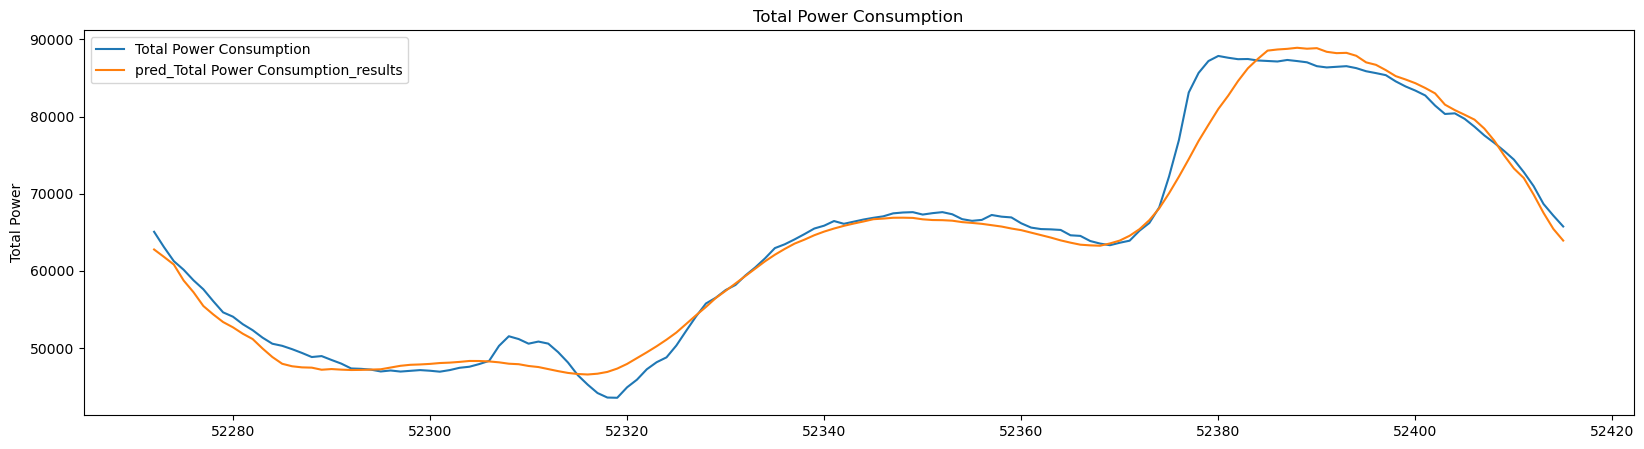

In [76]:
# Plot the "Total Power Consumption" and "pred_Total Power Consumption_results" columns aagint the index
sdf_forecasted_final.plot(y=['Total Power Consumption', 'pred_Total Power Consumption_results'], kind="line", figsize=(20, 5))
plt.ylabel("Total Power")
plt.title( 'Total Power Consumption')
# Display the plot
plt.show()

## Conclusion <a class="anchor" id="42"></a>

In this deep learning time series notebook, we utilized newly implemented methods from the arcgis.learn library to forecast power consumption for the city of Tetouan at 10-minute intervals for an entire day. This involved predicting 144 future time steps.

These approaches included one-step univariate, one-step multivariate, and multi-step multivariate methods. The notebook provided detailed explanations for each methodology, including data processing and application for time series forecasting.

Further, the notebook introduced several novel deep learning architectures, including some specially designed for modelling timeseries data, that significantly enhanced the model's performance, evident in the high accuracy of the forecasted values compared to the actual values.

Overall, this notebook demonstrated the improvement of both multivariate approaches over the univariate approach, aligning with expectations.

Time series modeling is typically intricate, often requiring fine-tuning of numerous hyperparameters to achieve accurate results. However, this current implementation in the time series module encapsulates and simplifies these complexities, offering users an intuitive and flexible approach.

## Data resources <a class="anchor" id="43"></a>

| Dataset | Citation | Link |
| -| - |-|
|Power consumption of Tetouan city|Salam, A., & El Hibaoui, A. (2018, December). Comparison of Machine Learning Algorithms for the Power Consumption Prediction:-Case Study of Tetouan city“. In 2018 6th International Renewable and Sustainable Energy Conference (IRSEC) (pp. 1-5). IEEE.|https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city|

                                                           ------End-----